<a href="https://colab.research.google.com/github/AndreaM1996/Autoencoder-for-Physical-Layer/blob/master/Gmpi_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.layers import Input, Dense, Lambda, Embedding
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
n = 2
k = 4
M = 2**k
R = k/n

# **Load data**

In [0]:
rng = np.random.default_rng()
train = rng.integers(0, M, size=16000)
val = rng.integers(0, M, size=50000)
test = rng.integers(0, M, size=100000)

In [0]:
x_train = np.reshape(train, (len(train), 1))
x_val = np.reshape(val, (len(val), 1))
x_test = np.reshape(test, (len(test), 1))

# **Training autoencoder**

In [0]:
def autoencoder(in_dim, n_dim, std):
  
  input_ = Input(shape=(1,))
    
  # Encoder layers - Transmitter
  encoded1 = Embedding(input_dim=M, output_dim=M, name='encoder_layer1', input_length=1)(input_)
  encoded2 = Dense(n_dim, activation='linear', name='encoder_layer2')(encoded1)

  # Normalization
  #normalized = Lambda(lambda x: np.sqrt(n_dim) * K.l2_normalize(x, axis=2), name='normalization')(encoded2) #energy constraint
  normalized = Lambda(lambda x: x / K.sqrt(K.mean(x**2)), name='normalization')(encoded2) #average power enegry constraint

  # Channel
  channel = Lambda(lambda x: x + K.random_normal(shape=(K.int_shape(x)[1],K.int_shape(x)[2]), mean=0, stddev=std, seed=42), name='channel')(normalized)

  # Decoder layers - Receiver
  decoded1 = Dense(in_dim, activation='relu', name='decoder_layer1')(channel)
  decoded2 = Dense(in_dim, activation='softmax', name='decoder_layer2')(decoded1)
  
  

  # Combine Encoder and Decoder layers
  autoencoder = Model(inputs = input_, outputs = decoded2)

  # Compile the Model 
  adam = optimizers.Adam(lr=0.001) 
  autoencoder.compile(optimizer = adam, loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
  
  encoder = Model(inputs=input_, outputs=normalized)

  return autoencoder, encoder

# **Performance**

In [0]:
def plot_bler_vs_ebno(blers, ebno):
  plt.figure(figsize=(6,6))
  plt.scatter(ebno, blers,label='autoencoder (7,4)')
  plt.yscale('log')
  plt.xlabel('$E_b$/$N_0$ [db]', fontsize=15)
  plt.ylabel('Block error rate', fontsize=15)
  plt.legend()
  plt.show()

In [0]:
snr = range(11)
blers = []
for db in snr:
  Eb_No = 10**(db/10)
  std = math.sqrt(1/(2 * R * Eb_No))
  ae, encoder = autoencoder(M, n, std)
  history = ae.fit(x_train, x_train, epochs = 50, batch_size = 100, shuffle = True, validation_data = (x_val, x_val))
  pred = ae.predict(x_test)
  pred = pred[:,0,:]
  predicted = np.argmax(pred, axis=1)
  diff = np.sum(test != predicted)
  bler = diff / predicted.shape[0]
  blers.append(bler)

Epoch 1/50
160/160 [==============================] - 1s 6ms/step - loss: 1.2501 - sparse_categorical_accuracy: 0.4623 - val_loss: 1.1404 - val_sparse_categorical_accuracy: 0.6228
Epoch 2/50
160/160 [==============================] - 1s 5ms/step - loss: 1.0141 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.9120 - val_sparse_categorical_accuracy: 0.7906
Epoch 3/50
160/160 [==============================] - 1s 5ms/step - loss: 0.8327 - sparse_categorical_accuracy: 0.7933 - val_loss: 0.7630 - val_sparse_categorical_accuracy: 0.7970
Epoch 4/50
160/160 [==============================] - 1s 5ms/step - loss: 0.7231 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.6997 - val_sparse_categorical_accuracy: 0.7721
Epoch 5/50
160/160 [==============================] - 1s 5ms/step - loss: 0.6564 - sparse_categorical_accuracy: 0.7882 - val_loss: 0.6186 - val_sparse_categorical_accuracy: 0.8125
Epoch 6/50
160/160 [==============================] - 1s 5ms/step - loss: 0.5955 - sparse_categorica

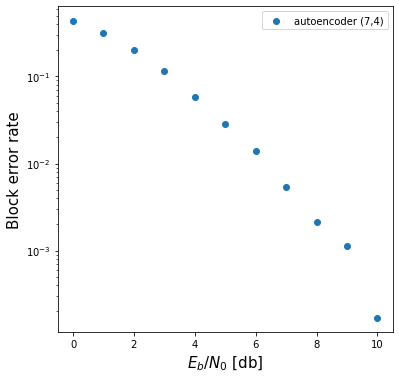

In [0]:
plot_bler_vs_ebno(blers, snr)

In [0]:
blers

[0.15216,
 0.1108,
 0.07557,
 0.04729,
 0.0273,
 0.01419,
 0.0062,
 0.0016,
 0.00062,
 7e-05,
 0.0]

#**Constellation**

In [0]:
from sklearn.manifold import TSNE
def constellation(model, test):
  cps = model.predict(test)
  cps = cps[:,0,:]
  if cps.shape[1] == 2:
    x, y = zip(*cps)
  else:
    tsne = TSNE(n_components=2, perplexity=15, learning_rate=100, early_exaggeration=10, n_iter=700)
    tsne_results = tsne.fit_transform(cps)
    x, y = zip(*tsne_results)

  return x, y

def plot_constellation(x, y):
  fig, ax = plt.subplots(figsize=(6,6))
  ax.scatter(x, y, color='k', s=0.5)
  #ax.set_xlim(-2,2)
  #ax.set_ylim(-2,2)
  ax.grid()
  plt.show()

In [0]:
Eb_No_tr = 10**(7/10)
std = math.sqrt(1/(2 * R * Eb_No_tr))
ae, encoder = autoencoder(M, n, std)

In [0]:
history = ae.fit(x_train, x_train, epochs = 50, batch_size = 100, shuffle = True, validation_data = (x_val, x_val))

Epoch 1/50
160/160 [==============================] - 1s 9ms/step - loss: 2.2220 - sparse_categorical_accuracy: 0.2748 - val_loss: 1.8958 - val_sparse_categorical_accuracy: 0.3882
Epoch 2/50
160/160 [==============================] - 1s 8ms/step - loss: 1.6489 - sparse_categorical_accuracy: 0.4411 - val_loss: 1.4496 - val_sparse_categorical_accuracy: 0.4668
Epoch 3/50
160/160 [==============================] - 1s 8ms/step - loss: 1.3174 - sparse_categorical_accuracy: 0.5301 - val_loss: 1.2000 - val_sparse_categorical_accuracy: 0.6067
Epoch 4/50
160/160 [==============================] - 1s 8ms/step - loss: 1.1220 - sparse_categorical_accuracy: 0.6382 - val_loss: 1.0563 - val_sparse_categorical_accuracy: 0.6575
Epoch 5/50
160/160 [==============================] - 1s 8ms/step - loss: 0.9910 - sparse_categorical_accuracy: 0.6972 - val_loss: 0.9273 - val_sparse_categorical_accuracy: 0.7582
Epoch 6/50
160/160 [==============================] - 1s 8ms/step - loss: 0.8747 - sparse_categorica

In [0]:
x, y = constellation(encoder, x_test)

In [0]:
minix = min(x)
maxix = max(x)
miniy = min(y)
maxiy = max(y)
k = [2*(xi - minix)/(maxix-minix) for xi in x]
l = [2*(xi - miniy)/(maxiy-miniy) for xi in y]

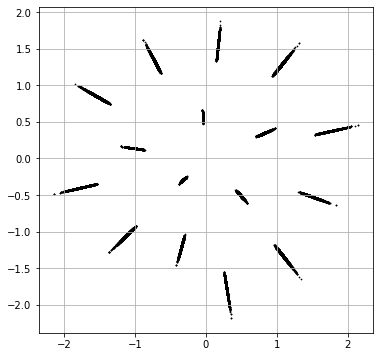

In [0]:
plot_constellation(x, y)

In [0]:
data = pd.DataFrame({'dim1': x, 'dim2': y})

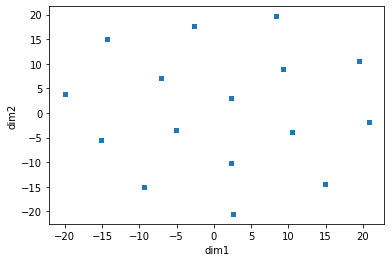

In [0]:
sns.scatterplot(x='dim1', y='dim2',data=data, alpha=0.003)

In [0]:
len(np.unique(y))

24

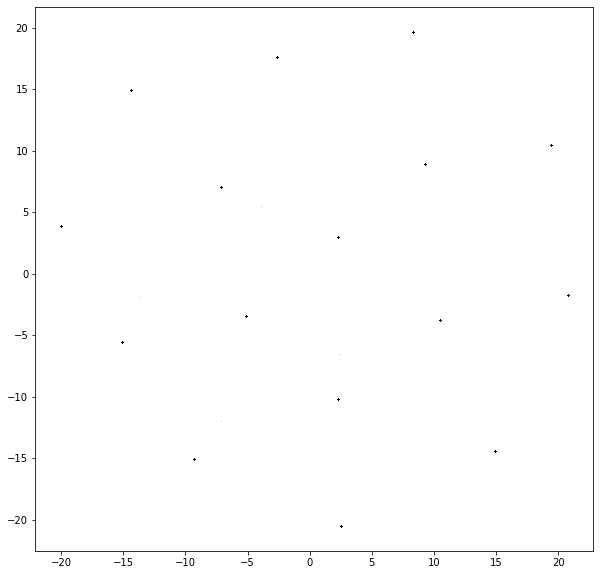

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, color='k', alpha=0.3, s=0.03, marker='x')
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)

plt.show()

In [0]:
def performance(model, true):
  x_true = np.reshape(train, (len(true), 1))
  y_pred = model.predict(x_true)
  y_pred = y_pred[:,0,:]
  indices = np.argmax(y_pred, axis=1)
 
  cm = confusion_matrix(true, indices)
  f1 = f1_score(true, indices, average=None)
  acc = accuracy_score(true, indices)
 
  df_cm = pd.DataFrame(cm)
  
  return df_cm, f1, acc

def plot_confusion_matrix(cm):
  sns.set(font_scale=0.7) # for label size
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 8})
  plt.title('Confusion matrix ')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [0]:
performance(ae, test)

Check batch size parameter

In [0]:
fig = plt.figure(figsize=(10,8))
db = 7
batches = [6, 12, 16, 24, 32]
#blers_test = []
for batch in batches:
  # We left compilation of model inside loop because we want a new network to train each time
  Eb_No = 10**(db/10)
  beta = variance(R, Eb_No)
  std = math.sqrt(beta)
  ae = autoencoder(M, n, std)
  history = ae.fit(x_train, x_train, epochs = 50, batch_size = batch, shuffle = True, validation_data = (x_val, x_val))
  
  ax1 = fig.add_subplot(121)
  plot_loss(history, batch, ax1)

  ax2 = fig.add_subplot(122)
  plot_accuracy(history, batch, ax2)

ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [0]:
cm, f1, acc = performance(ae, x_test)

In [0]:
plot_confusion_matrix(cm)